In [92]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.autograd import Variable

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


### Helper Function to visualize MNIST and FashionMNSIT dataset

In [93]:
import matplotlib.pyplot as plt
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

### Load the dataset

In [94]:
path = r'/kaggle/input/digit-recognizer/train.csv'
df = pd.read_csv(path)
y = torch.tensor(df['label'].values,dtype=torch.int64)
X = torch.tensor(df.drop('label',axis=1).values,dtype=torch.float32)

### Split the dataset for training and validation

In [95]:
from sklearn.model_selection import train_test_split
X_train,X_test,ytrain,ytest = train_test_split(X,y,test_size=0.3,stratify=y)
print(X_train.shape,X_test.shape)

torch.Size([29400, 784]) torch.Size([12600, 784])


### Visualizing the dataset

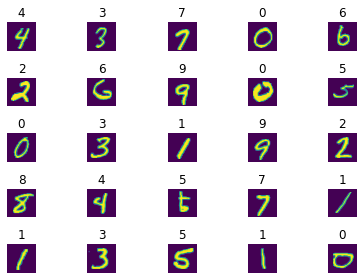

In [96]:
fig, ax = plt.subplots(5, 5)
fig.figsize = (10, 12)
for i in range (5):
    for j in range(5):
        ax[i, j].imshow(X_train[i*5 + j].view(28, 28))
        ax[i, j].set_title(ytrain[i*5 + j].item())
        ax[i, j].set_axis_off()
plt.tight_layout()
plt.show()

### Define the model

In [97]:
from torch import nn
from torch import optim

net = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
# optimizer = optim.Adam(net.parameters(), lr=0.003)
# One pass through entire dataset is called an epoch
epochs = 100
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for i in range(0,29400,200):
        # Flatten MNIST images into a 784 long vector
        
        images = X_train[i:i+200]
        labels = ytrain[i:i+200]
        
        optimizer.zero_grad()
        
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            for i in range(0,12600,100):
                images = X_test[i:i+100]
                labels = ytest[i:i+100]
                log_ps = net(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(running_loss/200)
        test_losses.append(test_loss/100)
        
        print("Epoch: {}/{} ".format(e+1, epochs),
              "Training Loss: {} ".format(running_loss/200),
              "Test Loss: {} ".format(test_loss/100),
              "Test Accuracy: {}".format(accuracy/100))

Epoch: 1/100  Training Loss: 0.8028696842491627  Test Loss: 0.6400708556175232  Test Accuracy: 1.0723998546600342
Epoch: 2/100  Training Loss: 0.3072731300443411  Test Loss: 0.48473381996154785  Test Accuracy: 1.117300271987915
Epoch: 3/100  Training Loss: 0.23579170033335686  Test Loss: 0.41858604550361633  Test Accuracy: 1.1368000507354736
Epoch: 4/100  Training Loss: 0.19781167730689048  Test Loss: 0.3796095550060272  Test Accuracy: 1.1487001180648804
Epoch: 5/100  Training Loss: 0.17289776880294083  Test Loss: 0.3527906835079193  Test Accuracy: 1.1571999788284302
Epoch: 6/100  Training Loss: 0.15464419893920422  Test Loss: 0.33239495754241943  Test Accuracy: 1.1618000268936157
Epoch: 7/100  Training Loss: 0.1403230471536517  Test Loss: 0.31637755036354065  Test Accuracy: 1.1669001579284668
Epoch: 8/100  Training Loss: 0.12853250686079265  Test Loss: 0.30366143584251404  Test Accuracy: 1.170199990272522
Epoch: 9/100  Training Loss: 0.11868101391941309  Test Loss: 0.2927699685096741 

### Visualize training and test losses

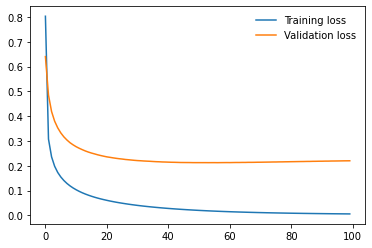

In [119]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show();

### Alternative Model Definition

In [99]:
# import torch.nn.functional as F
# class Classifier(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(784, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 10)

#         # Dropout module with 0.4 drop probability
#         self.dropout = nn.Dropout(p=0.4)

#     def forward(self, x):
#         # make sure input tensor is flattened
#         x = x.view(x.shape[0], -1)

#         # Now with dropout
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(F.relu(self.fc2(x)))

#         # output so no dropout here
#         x = F.log_softmax(self.fc3(x), dim=1)

#         return x

In [100]:
# net = Classifier()
# criterion = nn.NLLLoss()
# # optimizer = optim.SGD(net.parameters(), lr=0.001)
# optimizer = optim.Adam(net.parameters(), lr=0.01)
# # One pass through entire dataset is called an epoch
# epochs = 100
# train_losses, test_losses = [], []
# for e in range(epochs):
#     running_loss = 0
#     for i in range(0,29400,200):
#         # Flatten MNIST images into a 784 long vector
        
#         images = X_train[i:i+200]
#         labels = ytrain[i:i+200]
        
#         optimizer.zero_grad()
        
#         output = net(images)
#         loss = criterion(output, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#     else:
#         test_loss = 0
#         accuracy = 0
#         with torch.no_grad():
#             for i in range(0,12600,100):
#                 images = X_test[i:i+100]
#                 labels = ytest[i:i+100]
#                 log_ps = net(images)
#                 test_loss += criterion(log_ps, labels)
                
#                 ps = torch.exp(log_ps)
#                 top_p, top_class = ps.topk(1, dim=1)
#                 equals = top_class == labels.view(*top_class.shape)
#                 accuracy += torch.mean(equals.type(torch.FloatTensor))
#         train_losses.append(running_loss/200)
#         test_losses.append(test_loss/100)
        
#         if e%10 == 0 :
#             print("Epoch: {}/{} ".format(e+1, epochs),
#                   "Training Loss: {} ".format(running_loss/200),
#                   "Test Loss: {} ".format(test_loss/100),
#                   "Test Accuracy: {}".format(accuracy/100))

In [101]:
# plt.plot(train_losses, label='Training loss')
# plt.plot(test_losses, label='Validation loss')
# plt.legend(frameon=False)

### Predict on Validation Dataset

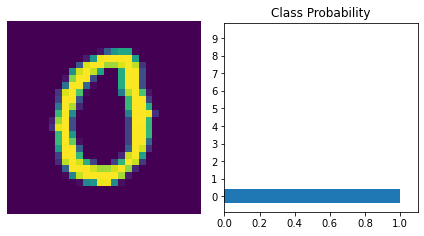

In [118]:
img = X_test[100].view(1, 784)
with torch.no_grad():
    logps = net(img)
ps = torch.exp(logps)
view_classify(img.view(1, 28, 28), ps)

### Accuracy of the model

In [117]:
with torch.no_grad():
    ypred = net(X)
    ps = torch.exp(ypred)
    top_p, top_class = ps.topk(1,dim=1)
    equals = top_class == y.view(*top_class.shape)
    accuracy = torch.mean(equals.type(torch.FloatTensor))
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.986


### Loading Testing DataSet

In [120]:
path = r'/kaggle/input/digit-recognizer/test.csv'
df = pd.read_csv(path)

In [126]:
X_test = torch.tensor(df.values,dtype=torch.float32)
print(X_test.size())

torch.Size([28000, 784])


### Predict on Test Dataset

In [122]:
with torch.no_grad():
    logps = net(X_test)
ps = torch.exp(logps)

In [123]:
ytest = torch.argmax(ps,axis=1)

### Visualize prediction on random image from Test Dataset

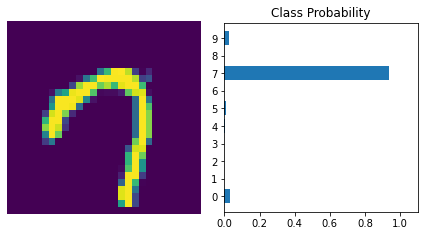

In [127]:
import random
idx = int(random.random()*X_test.size(0))
view_classify(X_test[idx].view(1, 28, 28), ps[idx])

### Save results in CSV Format

In [109]:
# ids = [i+1 for i in range(X_test.shape[0])]
# ans = pd.DataFrame({'ImageId':ids,'Label':ytest})

In [110]:
# ans.to_csv('output.csv', index = False)